In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
def get_zoomed_region(img, cX, cY, zoom_factor=2, output_size=(512, 512)):
    """Extracts and resizes a zoomed-in region centered at (cX, cY)."""
    h, w = img.shape[:2]
    
    # Define crop size (ensuring within bounds)
    crop_w, crop_h = w // (2 * zoom_factor), h // (2 * zoom_factor)
    x1, x2 = max(cX - crop_w, 0), min(cX + crop_w, w)
    y1, y2 = max(cY - crop_h, 0), min(cY + crop_h, h)

    # Crop the region and resize it to the output size
    cropped = img[y1:y2, x1:x2]
    zoomed = cv2.resize(cropped, output_size, interpolation=cv2.INTER_LINEAR)

    return zoomed

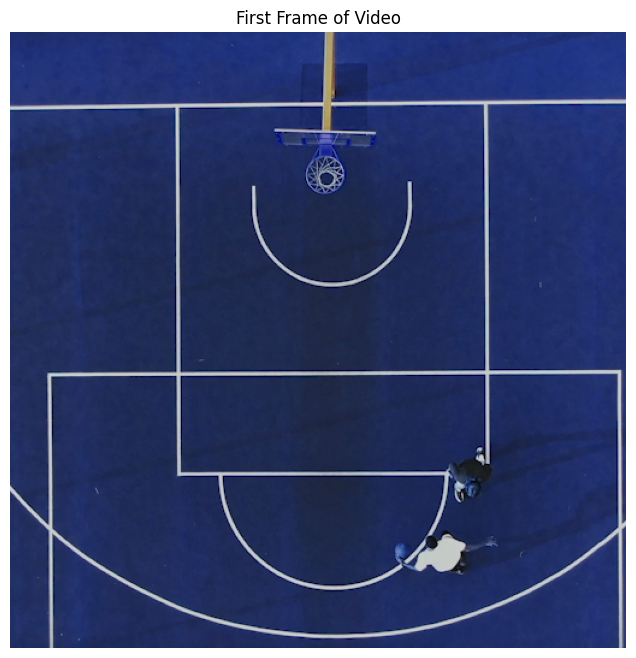

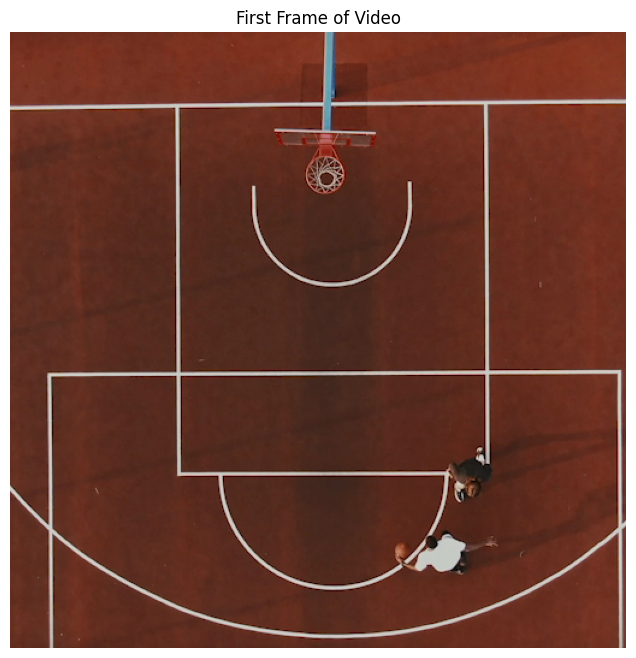

In [3]:
# Initialize video capture from file
vs = cv2.VideoCapture("./basketball.mp4")
if not vs.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the initial frame size
ret, frame = vs.read()
if not ret:
    print("Error: Could not read video file.")
    vs.release()
    exit()

# Create a figure and display the image
plt.figure(figsize=(10, 8))
plt.imshow(frame)
plt.axis('off')
plt.title('First Frame of Video')
plt.show()

# Convert from BGR to RGB for proper color display
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# Create a figure and display the image
plt.figure(figsize=(10, 8))
plt.imshow(frame_rgb)
plt.axis('off')
plt.title('First Frame of Video')
plt.show()


In [4]:
# Initialize the motion saliency object
saliency = cv2.saliency.MotionSaliencyBinWangApr2014.create()
height, width = frame.shape[:2]
saliency.setImagesize(width, height)
saliency.init()

True

In [5]:
# Kernel size for Gaussian blur to reduce noise
BLUR_KERNEL = (25, 25)

output_set_frames = []
while True:
    ret, frame = vs.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, BLUR_KERNEL, 0)

    success, saliencyMap = saliency.computeSaliency(gray)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    # Compute centroid
    M = cv2.moments(saliencyMap, binaryImage=True)
    if M["m00"] != 0:
        cX, cY = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
    else:
        cX, cY = None, None

    
    if cX is not None and cY is not None:

        # Extract zoomed-in region around the centroid
        zoomed_frame = get_zoomed_region(frame, cX, cY, zoom_factor=2)
        cv2.rectangle(frame, (cX-127, cY-127), (cX+128, cY+128), (0, 255, 0), 1)
    else:
        zoomed_frame = np.zeros((512, 512, 3), dtype=np.uint8)  # Placeholder

    output_set_frames.append((frame, saliencyMap, zoomed_frame))

vs.release()

In [7]:
# Create a figure to display the frames with higher DPI for better quality
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Turn off axes for all subplots
for ax in axs:
    ax.set_axis_off()

# Get the first frame components
frame, saliency_map, zoomed = output_set_frames[0]

# Convert from BGR to RGB for proper display
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
saliency_map_rgb = cv2.cvtColor(saliency_map, cv2.COLOR_GRAY2RGB)
zoomed_rgb = cv2.cvtColor(zoomed, cv2.COLOR_BGR2RGB)

# Set titles for each subplot
axs[0].set_title('Original Frame')
axs[1].set_title('Saliency Map')
axs[2].set_title('Zoomed Region')

# Set initial images
img1 = axs[0].imshow(frame_rgb)
img2 = axs[1].imshow(saliency_map_rgb)
img3 = axs[2].imshow(zoomed_rgb)

def update(i):
    # Get the frame components
    frame, saliency_map, zoomed = output_set_frames[i]
    
    # Convert from BGR to RGB for proper display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    saliency_map_rgb = cv2.cvtColor(saliency_map, cv2.COLOR_BGR2RGB)
    zoomed_rgb = cv2.cvtColor(zoomed, cv2.COLOR_BGR2RGB)
    
    # Update the images
    img1.set_array(frame_rgb)
    img2.set_array(saliency_map_rgb)
    img3.set_array(zoomed_rgb)
    
    return [img1, img2, img3]

# Create animation with optimized parameters
ani = FuncAnimation(fig, update, frames=len(output_set_frames), interval=1000//25, blit=True)

# Use HTML5 video for more efficient playback
html_video = HTML(ani.to_html5_video())
plt.close(fig)  # Close the figure to prevent display of the static plot

# Display the animation in the notebook
html_video